**Image Classification of Birds using Convolutional Neural Network**

In [1]:
import os
import tensorflow as tf
import glob
import pathlib
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import keras
from keras.preprocessing.image import ImageDataGenerator as IDG
from keras.applications.vgg16 import preprocess_input
from keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense,Conv2D,Flatten, Dropout
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input



In [2]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


**Exploratory Data Analysis**

In [5]:
train_path="../content/gdrive/MyDrive/20-bird-species/Train"
test_path = "../content/gdrive/MyDrive/20-bird-species/Test"
valid_path = "../content/gdrive/MyDrive/20-bird-species/Valid"

In [6]:
birds = np.array(list(os.listdir(train_path)))

idx_to_name = {i:x for (i,x) in enumerate(birds)}
name_to_idx = {x:i for (i,x) in enumerate(birds)}
print(idx_to_name)

{0: 'YELLOW CACIQUE', 1: 'WHITE THROATED BEE EATER', 2: 'WOOD DUCK', 3: 'WILSONS BIRD OF PARADISE', 4: 'YELLOW BELLIED FLOWERPECKER', 5: 'YELLOW HEADED BLACKBIRD', 6: 'WILD TURKEY', 7: 'WHITE TAILED TROPIC', 8: 'WHITE NECKED RAVEN', 9: 'WHITE CHEEKED TURACO', 10: 'VULTURINE GUINEAFOWL', 11: 'WATTLED CURASSOW', 12: 'VIOLET GREEN SWALLOW', 13: 'VICTORIA CROWNED PIGEON', 14: 'VERMILION FLYCATHER', 15: 'WALL CREAPER', 16: 'WHITE BROWED CRAKE', 17: 'WHIMBREL', 18: 'VARIED THRUSH', 19: 'VENEZUELIAN TROUPIAL'}


In [7]:
def process(data):
    path=pathlib.Path(data)
    filepaths=list(path.glob(r"*/*.jpg"))
    labels=list(map(lambda x: os.path.split(os.path.split(x)[0])[1],filepaths))
    df1=pd.Series(filepaths,name='filepaths').astype(str)
    df2=pd.Series(labels,name='labels')
    df=pd.concat([df1,df2],axis=1)
    return df

In [8]:
df_train=process(train_path)
df_test=process(test_path)
df_valid=process(valid_path)
df_train.head(3)

,filepaths,labels
0,../content/gdrive/MyDrive/20-bird-species/Trai...,YELLOW CACIQUE
1,../content/gdrive/MyDrive/20-bird-species/Trai...,YELLOW CACIQUE
2,../content/gdrive/MyDrive/20-bird-species/Trai...,YELLOW CACIQUE


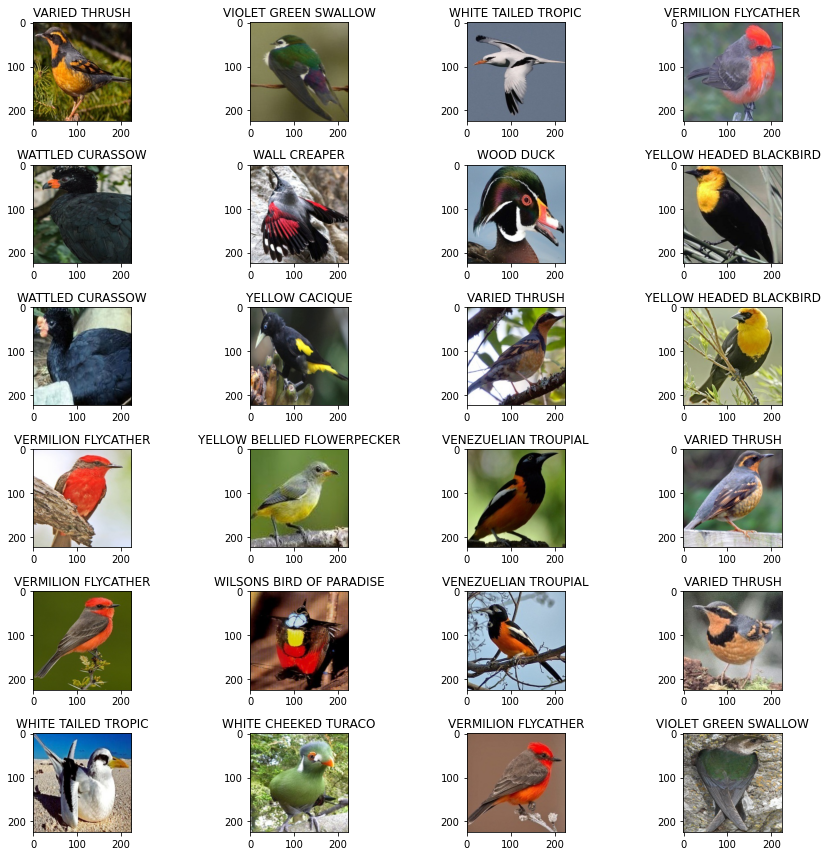

In [10]:
df_train=df_train.sample(frac=1).reset_index(drop=True)
fig,axes=plt.subplots(nrows=6,ncols=4,figsize=(12,12))

for i,ax in enumerate(axes.flat):
    x=plt.imread(df_train['filepaths'][i])
    ax.imshow(x)
    ax.set_title(df_train['labels'][i])
plt.tight_layout()    
plt.show() 

**Running the Image Data Generator**

In [11]:
train_gen=IDG(preprocessing_function=preprocess_input, shear_range=0.1, zoom_range=0.1, horizontal_flip=True)
test_gen=IDG(preprocessing_function=preprocess_input)
valid_gen=IDG(preprocessing_function=preprocess_input)

train_image=train_gen.flow_from_dataframe(dataframe=df_train, x_col='filepaths', y_col='labels', target_size=(225,225),
                                          batch_size=20, subset='training', class_mode="categorical")

test_image = test_gen.flow_from_dataframe(dataframe=df_test, x_col='filepaths', y_col='labels',
                                          target_size=(225,225), batch_size=20, class_mode="categorical")

valid_image = test_gen.flow_from_dataframe(dataframe=df_valid, x_col='filepaths', y_col='labels',
                                                 subset='training', target_size=(225,225), batch_size=20, class_mode="categorical")

Found 3217 validated image filenames belonging to 20 classes.
Found 3217 validated image filenames belonging to 20 classes.
Found 3217 validated image filenames belonging to 20 classes.


**Training the CNN (VGG16)**

In [12]:
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

vgg_model.trainable = False

model = keras.Sequential()
model.add(vgg_model.layers[0])
model.add(Flatten())
model.add(Dense(2048, activation="relu", kernel_initializer="he_normal"))
model.add(Dropout(0.35))
model.add(Dense(2048, activation="relu", kernel_initializer="he_normal"))
model.add(Dropout(0.35))
model.add(Dense(20, activation="softmax", kernel_initializer="glorot_normal"))
model.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 150528)            0         
                                                                 
 dense (Dense)               (None, 2048)              308283392 
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 2048)              4196352   
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 20)                40980     
                                                         

In [16]:
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

vgg_model.trainable = False

layer0 = tf.keras.layers.Flatten(name='flatten')(vgg_model.output)
layer1 = tf.keras.layers.Dense(4096, activation='relu',name='fc1')(layer0)
layer2 = tf.keras.layers.Dense(4096, activation='relu',name='fc2')(layer1)
out_layer = tf.keras.layers.Dense(20, activation='softmax')(layer2)
vgg_model = tf.keras.Model(vgg_model.input, out_layer)
vgg_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [17]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
vgg_model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=['accuracy'])


In [18]:
callbacks = EarlyStopping(monitor='accuracy', min_delta=0.001,
                          patience=3, mode='auto', verbose=2,
                          baseline=None)
history = vgg_model.fit(
      train_image, 
      epochs=10,
      verbose=1,
      validation_data = valid_image,
      callbacks=callbacks)

Epoch 1/10
161/161 [==============================] - 2426s 15s/step - loss: 4.5309 - accuracy: 0.8001 - val_loss: 0.7147 - val_accuracy: 0.9503
Epoch 2/10
161/161 [==============================] - 97s 603ms/step - loss: 0.7300 - accuracy: 0.9403 - val_loss: 0.3783 - val_accuracy: 0.9639
Epoch 3/10
161/161 [==============================] - 97s 604ms/step - loss: 0.3714 - accuracy: 0.9661 - val_loss: 0.2432 - val_accuracy: 0.9795
Epoch 4/10
161/161 [==============================] - 97s 601ms/step - loss: 0.5499 - accuracy: 0.9627 - val_loss: 0.2402 - val_accuracy: 0.9848
Epoch 5/10
161/161 [==============================] - 97s 602ms/step - loss: 0.4009 - accuracy: 0.9674 - val_loss: 0.0998 - val_accuracy: 0.9913
Epoch 6/10
161/161 [==============================] - 97s 604ms/step - loss: 0.2491 - accuracy: 0.9801 - val_loss: 0.2206 - val_accuracy: 0.9845
Epoch 7/10
161/161 [==============================] - 97s 600ms/step - loss: 0.3918 - accuracy: 0.9758 - val_loss: 0.3046 - val_ac

**Evaluation on Test Images**

In [19]:
vgg_model.evaluate(test_image,use_multiprocessing=True,workers=10)

161/161 [==============================] - 105s 651ms/step - loss: 0.2012 - accuracy: 0.9863


[0.20115381479263306, 0.9863226413726807]